In [2]:

import os
import pickle
import pandas as pandas
import numpy as np
import graphviz
import pydot
import tensorflow as tf
from tqdm.auto import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


from PIL import Image
from io import BytesIO
import gc


In [3]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [4]:
BASE_DIR = "F:\image captioning\kaggle\input\Flickr30k"
WORKING_DIR = 'F:\image captioning\kaggle\working'



In [5]:
# load vgg16 model
model = VGG16(weights='imagenet')
model.layers.pop()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
print(os.getcwd())

F:\image captioning


In [7]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    
    

In [8]:
# # store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features30.pkl'), 'wb'))


In [9]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features30.pkl'), 'rb') as f:
    features = pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r',encoding='utf-8') as f:
    next(f)
    captions_doc = f.read()


In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [12]:
len(mapping)


31783

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption


In [14]:
# before preprocess of text
mapping['36979']

[' A group of friends playing cards and trying to bluff each other into making a terrible mistake .',
 ' A group of college students gathers to play texas hold em poker .',
 ' Several men play cards while around a green table .',
 ' A group of several men playing poker .',
 ' Six white males playing poker .']

In [15]:
clean(mapping)


In [16]:
# mapping['1000268201_693b08cb0e']

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [18]:
len(all_captions)

158915

In [19]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes ." endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size


18314

In [22]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

75

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [24]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [25]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

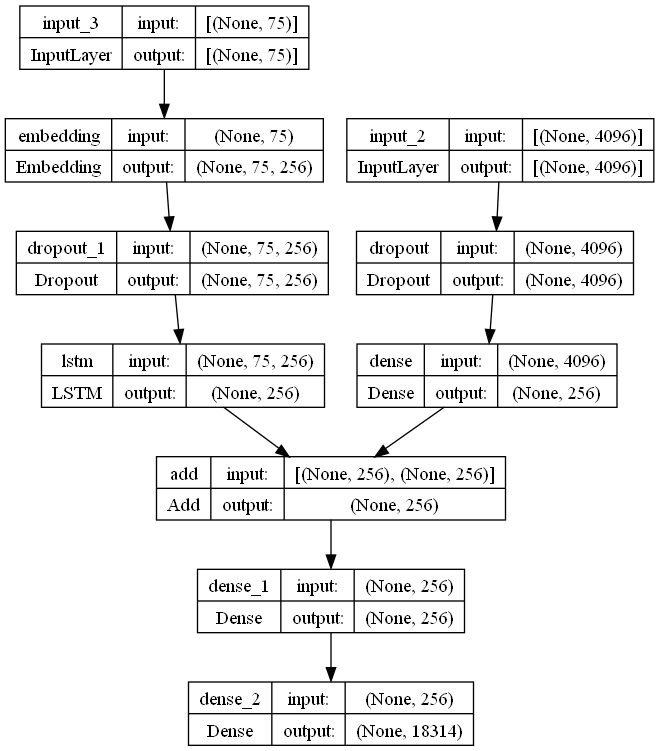

In [26]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [28]:
# train the model
epochs = 55
batch_size = 8
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     K.clear_session()
#     gc.collect()

C:\Users\SATYANKAR\anaconda31\envs\snakes\lib\site-packages\ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


3575/3575 [==============================] - 1163s 325ms/step - loss: 2.8679


In [29]:

# save the model
model.save(WORKING_DIR+'/model30k.h5')
model.save(WORKING_DIR+'/model30k.keras')

In [30]:

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# # save the model
# model.save(WORKING_DIR+'/model30k.h5')

In [32]:
import tensorflow as tf
model = tf.keras.models.load_model("F:\image captioning\kaggle\working\model30k.h5")

In [33]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [34]:
# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in tqdm(test):
#     # get actual caption
#     captions = mapping[key]
#     # predict the caption for image
#     y_pred = predict_caption(model, features[key], tokenizer, max_length) 
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)
    
# # calcuate BLEU score
# print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [35]:
tf.keras.backend.clear_session
gc.collect()

13411

In [36]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]

    y_pred = predict_caption(model, features[key], tokenizer, max_length) 

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
bleu1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(actual, predicted, weights=(0.33,0.33,0.33, 0))
bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

print("BLEU-1: %f" % bleu1)
print("BLEU-2: %f" % bleu2)
print("BLEU-3: %f" % bleu3)
print("BLEU-4: %f" % bleu4)

100%|██████████████████████████████████████████████████████████████████████████████| 3179/3179 [54:24<00:00,  1.03s/it]


BLEU-1: 0.531468
BLEU-2: 0.278346
BLEU-3: 0.161726
BLEU-4: 0.088184


In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq group of friends playing cards and trying to bluff each other into making terrible mistake endseq
startseq group of college students gathers to play texas hold em poker endseq
startseq several men play cards while around green table endseq
startseq group of several men playing poker endseq
startseq six white males playing poker endseq
--------------------Predicted--------------------
startseq two men are working on project endseq


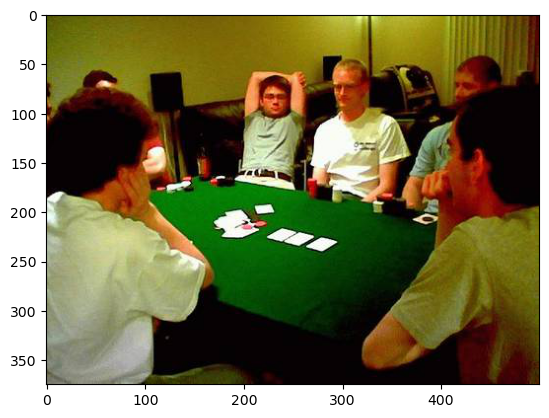

In [32]:
generate_caption("36979.jpg")

In [33]:

generate_caption("1002674143_1b742ab4b8.jpg")

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\image captioning\\kaggle\\input\\Flickr30k\\Images\\1002674143_1b742ab4b8.jpg'

In [ ]:

generate_caption("101669240_b2d3e7f17b.jpg")

In [34]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [35]:
image_path = 'F:\image captioning\kaggle\input\Flickr8k\Images\Formalphoto.jpeg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in blue shirt is playing tennis endseq'

In [36]:
image_path = 'F:\image captioning\kaggle\input\Flickr8k\Images\Satya1.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in blue shirt is sitting on stool in front of an old fashioned video camera endseq'

In [37]:
image_path = 'F:\image captioning\kaggle\input\Flickr8k\Images\Satya.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in blue shirt is sitting on stool crafting pencil endseq'

In [38]:
image_path = 'F:\image captioning\kaggle\input\Flickr8k\Images\satya3.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in blue shirt is sitting on granite table with his head on his head endseq'

# import matplotlib.pyplot as plt

# Assuming you have train_loss, val_loss, train_accuracy, val_accuracy lists
# Visualize Epoch vs. Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs. Loss')
plt.legend()

# Visualize Epoch vs. Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs. Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Assuming you have actual and predicted values for METEOR calculation
# Calculate METEOR score
from nltk.translate import meteor_score

meteor_scores = [meteor_score.single_meteor_score(actual[i], predicted[i]) for i in range(len(actual))]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score: {:.4f}".format(average_meteor_score))

In [49]:
# losses = []
# accuracies = []

# # Train the model and collect training history
# for i in range(epochs):
#     # create data generator
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     # fit for one epoch and get history
#     history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
#     # Append loss and accuracy to the history lists
#     losses.append(history.history['loss'][0])
#     accuracies.append(history.history['accuracy'][0])

#     # ... (any other code you want to execute after each epoch)

# # Save the model
# model.save(WORKING_DIR+'/best_model.h5')

# # Plotting epoch vs. loss
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, epochs + 1), losses, marker='o', color='b', label='Training Loss')
# plt.title('Epoch vs. Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# # Plotting epoch vs. accuracy
# plt.subplot(1, 2, 2)
# plt.plot(range(1, epochs + 1), accuracies, marker='o', color='r', label='Training Accuracy')
# plt.title('Epoch vs. Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()